In [1]:
from utils.Trainer import Trainer
import semantic.SemanticSegmentationModules as ssm
import RegressorModules as rm
import InstanceSegmentationModules as ism 
from utils.Metrics import InstanceSegMetrics

import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import albumentations as A
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [3]:
data_path = 'drive/MyDrive/CVPPPSegmData/'
split = pd.read_csv(data_path + 'split.csv')
split.head()

,split,img_path,sem_path,inst_path
0,train,data/A1/plant001_rgb.png,data/A1/plant001_fg.png,data/A1/plant001_label.png
1,train,data/A1/plant005_rgb.png,data/A1/plant005_fg.png,data/A1/plant005_label.png
2,train,data/A1/plant006_rgb.png,data/A1/plant006_fg.png,data/A1/plant006_label.png
3,train,data/A1/plant007_rgb.png,data/A1/plant007_fg.png,data/A1/plant007_label.png
4,train,data/A1/plant008_rgb.png,data/A1/plant008_fg.png,data/A1/plant008_label.png


Сформируем датасет

In [5]:
transform_train = A.Compose([
                A.Resize(400, 400),
                A.GaussNoise(p=0.5, mean=0),
                A.ShiftScaleRotate(p=0.8, rotate_limit=180, shift_limit_x=0.07, shift_limit_y=0.1),
                A.RandomBrightnessContrast(p=0.9)
            ]) # Агументации 

transform_test = A.Compose([
                A.Resize(400, 400)
            ])

In [ ]:
train_dataset = rm.LeavesRegressorDataset(data_path, split[split.split == 'train'], transform=transform_train)
val_dataset = rm.LeavesRegressorDataset(data_path, split[split.split == 'dev'].reset_index(drop=True), transform=transform_test)
test_dataset = rm.LeavesRegressorDataset(data_path, split[split.split == 'test'].reset_index(drop=True), transform=transform_test)

Обучим модель

In [13]:
unet = ssm.UNet(3, 1, 10)
unet.load_state_dict(torch.load("state150.pth", map_location=torch.device("cpu"))["model"])

<All keys matched successfully>

epoch: 30
train loss: 0.056407824493526076
val diff: -0.7428571428571429
val abs_diff: 0.9714285714285714


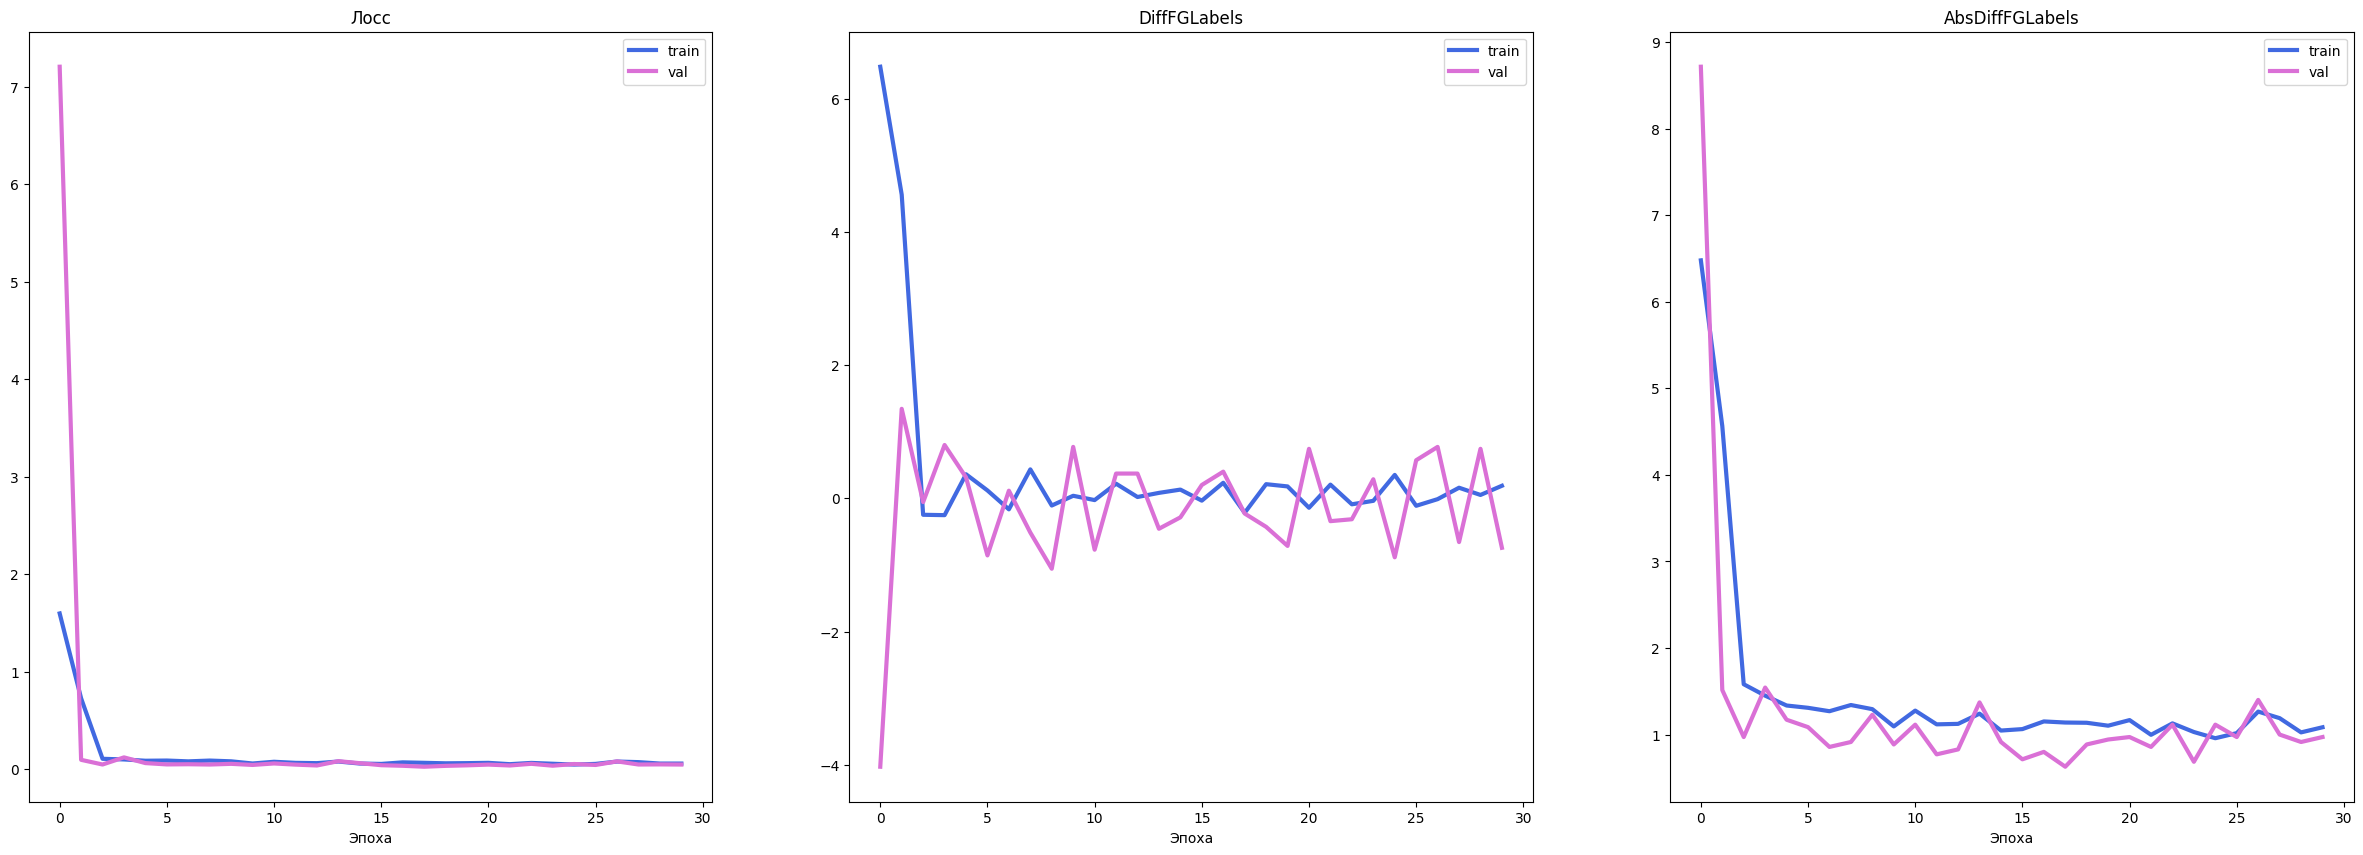

In [ ]:
device = "cuda"
model = rm.RegressorModel(old_model.backbone, 10)
model.to(device)

params = {
    "batch_size": 40,
    "num_workers": 1,
    "device": device,
    "lr": 7e-3,
    "epochs": 30,
    "path": "sample_data/regressor10.pth"
}

trainer = Trainer(InstanceSegMetrics, ['DiffFGLabels', 'AbsDiffFGLabels'])
model, opt, history = trainer.train_and_test(model, train_dataset, val_dataset, params)

Посчитаем метрики

In [15]:
device = "cuda"
reg = rm.RegressorModel(unet.backbone, 10)
reg.load_state_dict(torch.load("regressor100.pth", map_location=torch.device("cpu"))["model"])

<All keys matched successfully>

In [ ]:
params = {
    "batch_size": 64,
    "num_workers": 1,
    "device": device,
    "lr": 7e-4,
    "epochs": 50,
    "path": "sample_data/regressor50.pth"
}

test_loader = DataLoader(
        test_dataset,
        batch_size=6,
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

In [ ]:
reg.to(device)
criterion = nn.MSELoss().to(params["device"])
test_loss, test_diff, test_abs_diff = eval(test_loader, reg, criterion, 150, params)
print('Test DiffFGLabels: ', test_diff)
print('Test AbsDiffFGLabels: ', test_abs_diff)

Test DiffFGLabels:  0.047619047619047616
Test AbsDiffFGLabels:  0.5238095238095238


Теперь перейдем к кластеризации

In [31]:
unet = ssm.UNet(3, 1, 10)
unet.load_state_dict(torch.load("state150.pth", map_location=torch.device('cpu'))["model"])

<All keys matched successfully>

In [18]:
train_dataset = ism.LeavesIntanceSegmDataset(data_path, split[split.split == 'train'].reset_index(drop=True), transform=transform_test)
val_dataset = ism.LeavesIntanceSegmDataset(data_path, split[split.split == 'dev'].reset_index(drop=True), transform=transform_test)
test_dataset = ism.LeavesIntanceSegmDataset(data_path, split[split.split == 'test'].reset_index(drop=True), transform=transform_test)

Посмотрим на примере, как оно кластеризует

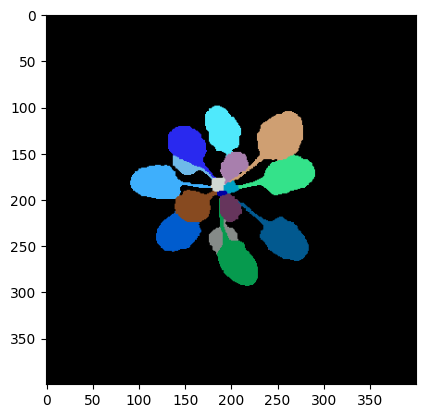

CPU times: user 202 ms, sys: 102 ms, total: 304 ms
Wall time: 198 ms


In [ ]:
%%time
plt.imshow(val_dataset[0][1].T)
plt.show()

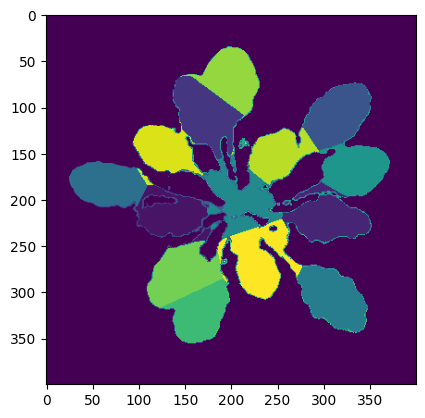

0.6808100933599461

In [41]:
ism.InstanseSegmentation(test_dataset[0], unet, reg, 'cpu', True)

Посчитаем метрику

In [40]:
result = 0
for i in tqdm(range(len(test_dataset))):
  result += ism.InstanseSegmentation(test_dataset[i], unet, reg)

print()
print(result / len(test_dataset))

100%|██████████| 63/63 [02:09<00:00,  2.05s/it]


0.5313722649418313
